In [1]:
import FinanceDataReader as fdr
import asyncio
import numpy as np
import pandas 
import pandas as pd

class StkPrice:
    def __init__(self):
        self.cap = fdr.StockListing('KRX-MARCAP')
        self.cap = self.cap.loc[:,['Code','Marcap']]
        self.cap.set_index('Code',inplace=True)
    async def getPrice(self, code: str):
        res = fdr.DataReader(code)['Close']
        return res
    async def getMarketCap(self, code: str):
        return self.cap.loc[code]['Marcap']

In [2]:
code = ['055550','003550','009200','000990','031440','009150','024110']
loader = StkPrice()
df = [await loader.getPrice(c) for c in code]
cap = [await loader.getMarketCap(c) for c in code]

In [3]:
cap

[19158089792850,
 13323394107100,
 113593416300,
 1995716530600,
 184717296000,
 10046302112000,
 8224521486350]

In [4]:
df = pd.DataFrame(df).T
df.columns = code

In [5]:
df = df.dropna()

In [6]:
rtn = ((df.shift(90) - df)/df).dropna()

In [7]:
rtn_cov = rtn.corr()

In [8]:
w_mkt = np.array(cap)/np.sum(cap)
w_mkt

array([0.36115765, 0.25116522, 0.0021414 , 0.03762214, 0.00348219,
       0.1893873 , 0.1550441 ])

In [9]:
expected_rtn = rtn.mean().multiply(w_mkt).sum()

In [10]:
expected_rtn

-0.0036632607819802082

In [11]:
portfolio_variance = w_mkt.dot(rtn_cov).dot(w_mkt)
lambd = expected_rtn / portfolio_variance

In [12]:
lambd

-0.005771858945596665

In [13]:
Pi = lambd * rtn_cov.dot(w_mkt)

In [14]:
Pi

055550   -0.004155
003550   -0.003687
009200   -0.002307
000990   -0.002178
031440   -0.002450
009150   -0.002806
024110   -0.003933
dtype: float64

In [182]:
Q = np.array([ 0.07669642,  0.09424969,  0.18199817,  0.12835284, -0.02027411, 0.13328767,  0.10802241])
#Q = np.array([ 1 for i in range(7)])
P = np.eye(len(code))
tau = 1/len(code)

In [183]:
P

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

In [184]:
# P[0,0] = -1
# P[0,1] = 1
# P[1,1] = 1
# P[1,3] = -1
# P[2,2] = -1
# P[2,4] = 0.5
# P[2,1] = 0.5
#P[0,0] = 1
#P[1,1] = 1
#P[2,2] = 1

In [185]:
P

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

In [186]:
Omega = tau * P.dot(rtn_cov).dot(P.T) * np.eye(len(Q))

In [187]:
Omega

array([[0.14285714, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.14285714, 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.14285714, 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.14285714, 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.14285714,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.14285714, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.14285714]])

In [188]:
from numpy.linalg import inv
ER = Pi * tau * rtn_cov.dot(P.T).dot(inv(P.dot(tau*rtn_cov).dot(P.T)+Omega).dot(Q-P.dot(Pi)))

In [189]:
ER

055550   -0.000336
003550   -0.000296
009200   -0.000247
000990   -0.000190
031440   -0.000092
009150   -0.000232
024110   -0.000322
dtype: float64

In [190]:
w_hat = inv(rtn_cov).dot(ER)

In [191]:
w_hat = pd.Series(w_hat / w_hat.sum(), index=code)
w_hat

055550    0.260414
003550    0.207392
009200    0.260432
000990    0.067376
031440   -0.424697
009150    0.271841
024110    0.357242
dtype: float64

In [192]:
np.sum(w_hat)

1.0

In [193]:
df = df.loc['2021-01-01':]

In [194]:
tr = (df.apply(lambda x : x/df.iloc[0],axis=1) * w_hat).sum(axis=1)

In [195]:
df

,055550,003550,009200,000990,031440,009150,024110
Date,,,,,,,
2021-01-04,31550.0,91538.0,2715.0,51100.0,65900.0,180000.0,8620.0
2021-01-05,32100.0,92860.0,2720.0,49900.0,65700.0,180000.0,8710.0
2021-01-06,32400.0,91916.0,2700.0,53600.0,65500.0,176000.0,8700.0
2021-01-07,33750.0,101551.0,2785.0,54000.0,66300.0,182000.0,8870.0
2021-01-08,33650.0,99662.0,2755.0,54900.0,66000.0,193000.0,8830.0
...,...,...,...,...,...,...,...
2022-11-23,36400.0,82900.0,2695.0,46700.0,49200.0,133500.0,10950.0
2022-11-24,37050.0,84200.0,2770.0,46700.0,48300.0,135500.0,11050.0
2022-11-25,36550.0,85000.0,2735.0,45950.0,48100.0,134000.0,11050.0


In [196]:
tr

Date
2021-01-04    1.000000
2021-01-05    1.011451
2021-01-06    1.009582
2021-01-07    1.062186
2021-01-08    1.072278
                ...   
2022-11-23    1.146703
2022-11-24    1.175173
2022-11-25    1.167536
2022-11-28    1.155976
2022-11-29    1.174994
Length: 472, dtype: float64

No handles with labels found to put in legend.


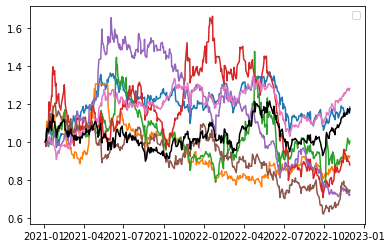

In [197]:
import matplotlib.pyplot as plt
plt.plot(df.apply(lambda x : x/df.iloc[0],axis=1))
plt.plot(tr,color='black')
plt.legend()
plt.show()

In [198]:
rtn_cov

,055550,003550,009200,000990,031440,009150,024110
055550,1.000000,0.571098,0.452629,0.382716,0.453679,0.357838,0.842311
003550,0.571098,1.000000,0.366642,0.324573,0.347196,0.425047,0.558878
009200,0.452629,0.366642,1.000000,0.430501,0.438697,0.293704,0.442391
000990,0.382716,0.324573,0.430501,1.000000,0.396459,0.232471,0.474581
031440,0.453679,0.347196,0.438697,0.396459,1.000000,0.371526,0.539986
009150,0.357838,0.425047,0.293704,0.232471,0.371526,1.000000,0.322716
024110,0.842311,0.558878,0.442391,0.474581,0.539986,0.322716,1.000000


In [199]:
rtn

,055550,003550,009200,000990,031440,009150,024110
Date,,,,,,,
2002-01-22,-0.369414,-0.294393,-0.419403,-0.004491,-0.384559,-0.258727,-0.370988
2002-01-23,-0.359915,-0.337833,-0.452247,-0.007485,-0.420714,-0.274194,-0.379665
2002-01-24,-0.465601,-0.428029,-0.532958,-0.170588,-0.486331,-0.363992,-0.467419
2002-01-25,-0.457277,-0.430182,-0.464888,-0.202201,-0.487365,-0.408922,-0.450307
2002-01-28,-0.492498,-0.509172,-0.545578,-0.285141,-0.594839,-0.454887,-0.496368
...,...,...,...,...,...,...,...
2022-11-23,-0.049451,-0.073583,-0.076067,-0.112420,0.140244,-0.003745,-0.171689
2022-11-24,-0.082321,-0.097387,-0.097473,-0.082441,0.173913,-0.025830,-0.182805
2022-11-25,-0.086183,-0.107059,-0.096892,-0.062024,0.195426,0.037313,-0.196380
